In [1]:
from lstmad.vrae import VRAE
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from lstmad.lstmae import RecurrentAutoencoder, train_model

import matplotlib.pyplot as plt

RANDOM_SEED = 666

### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data

In [232]:
train_df = pd.read_csv('data/ECG5000_TRAIN.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

test_df = pd.read_csv('data/ECG5000_TEST.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

In [245]:
df = train_df.append(test_df)
df = df.sample(frac=1.0)
df.target -=1
y = df['target']
X = df.drop(labels='target', axis=1)
y = (y>1.0).astype(int)

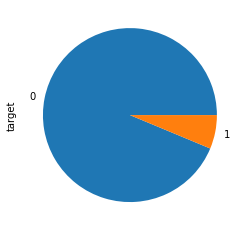

In [252]:
y.value_counts().plot.pie()

In [253]:
train_X, val_X, train_y, val_y = train_test_split(
  X, y,
  test_size=0.3,
  random_state=RANDOM_SEED
)

val_X, test_X, val_y, test_y = train_test_split(
  val_X, val_y,
  test_size=0.5, 
  random_state=RANDOM_SEED
)

In [254]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [255]:
train_dataset, seq_len, n_features = create_dataset(train_X)
val_dataset, _, _ = create_dataset(val_X)
test_dataset, _, _ = create_dataset(test_X)


In [256]:
model = RecurrentAutoencoder(seq_len, n_features, device, 8)
model = model.to(device)

In [257]:
# train_model(model,train_dataset,val_dataset, 50 , device)
# torch.save(model.state_dict(), 'autoencoder.pkl')

In [258]:
model.load_state_dict(torch.load('autoencoder.pkl'))

<All keys matched successfully>

In [259]:
train_errors, validation_errors, test_errors = [], [], []
train_dataset_np, val_dataset_np, test_dataset_np = [], [], []
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()


with torch.no_grad():
    
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        train_errors.append(loss.item())
        train_dataset_np.append(z.cpu().numpy().reshape(-1))
    
    for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        validation_errors.append(loss.item())
        val_dataset_np.append(z.cpu().numpy().reshape(-1))
        
    for seq_true in test_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        test_errors.append(loss.item())
        test_dataset_np.append(z.cpu().numpy().reshape(-1))

train_errors = np.array(train_errors)
validation_errors = np.array(validation_errors)
test_errors = np.array(test_errors)

train_dataset_np = np.array(train_dataset_np)
val_dataset_np = np.array(val_dataset_np)
test_dataset_np = np.array(test_dataset_np)

60.22487349200378

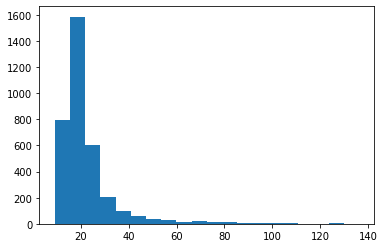

In [260]:
plt.hist(train_errors,bins=20)
train_errors.mean() + 3 * train_errors.std()

60.5474789899376

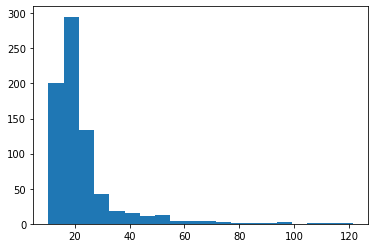

In [261]:
plt.hist(validation_errors,bins=20)
validation_errors.mean() + 3 * validation_errors.std()

55.77775549405595

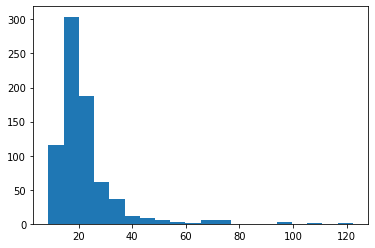

In [262]:
plt.hist(test_errors,bins=20)
test_errors.mean() + 3 * test_errors.std()

In [263]:
val_y.values[validation_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [264]:
test_y.values[test_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [265]:
train_y.values[train_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1])

In [266]:
# class AnomalyScoreProcessor(nn.Module):

#     def __init__(self, autoencoder, autoencoder_latent_dim, hidden_layer_dim, device):
#         super(AnomalyScoreProcessor, self).__init__()
#         self.autoencoder = autoencoder
#         for param in autoencoder.parameters():
#             param.requires_grad = False
#         self.hidden_layer_dim = hidden_layer_dim
#         self.hidden_layer = torch.nn.Linear(autoencoder_latent_dim + 1 , hidden_layer_dim).to(device)
#         self.relu = torch.nn.ReLU().to(device)
#         self.loss = nn.L1Loss(reduction='sum').to(device)

#     def forward(self, x):
#         z, out =  self.autoencoder(x)
#         anomaly_score = torch.abs(self.loss(out, x))
#         concatenated_tensor = torch.cat((z, anomaly_score.reshape(1, 1)), dim=1)
#         h = self.hidden_layer(concatenated_tensor)
#         rel = self.relu(h)
#         return rel

# class ExtendedAnomalyDetector(nn.Module):
    
#     def __init__(self, anomaly_score_processor, anomaly_score_processor_dim, class_nr, device):
#         super(ExtendedAnomalyDetector, self).__init__()
#         self.anomaly_score_processor = anomaly_score_processor
#         self.output_layer = torch.nn.Linear(anomaly_score_processor_dim, class_nr).to(device)
#         self.softmax = torch.nn.Softmax().to(device)
        
    
#     def forward(self, x):
#         out = self.anomaly_score_processor(x)
#         h = self.output_layer(out)
#         return self.softmax(h)
   

In [42]:
# asp = AnomalyScoreProcessor(model, 8, 4, device)
# ead = ExtendedAnomalyDetector(asp, 4, 2, device)

In [22]:
# def train_extended_anomaly_detector(model, x_train, y_train, x_val, y_val, n_epochs):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss().to(device)
#     history = dict(train=[], val=[])
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 10000.0
#     for epoch in range(1, n_epochs + 1):
#         model = model.train()
#         train_losses = []
#         for seq, y in zip(x_train, y_train):
#             optimizer.zero_grad()
#             seq = seq.to(device)
#             pred = model(seq)
#             #print(y)
#             loss = criterion(pred, torch.tensor(y).reshape(1).to(device))
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())
#         val_losses = []
#         model = model.eval()
#         with torch.no_grad():
#             for seq, y in zip(x_val, y_val):
#                 seq = seq.to(device)
#                 pred = model(seq)
#                 class_val = int(y>1)
#                 loss = criterion(pred, torch.tensor(class_val).reshape(1).to(device))
#                 val_losses.append(loss.item())
#         train_loss = np.mean(train_losses)
#         val_loss = np.mean(val_losses)
#         history['train'].append(train_loss)
#         history['val'].append(val_loss)
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model_wts = copy.deepcopy(model.state_dict())
#         print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
#     model.load_state_dict(best_model_wts)
#     return model.eval(), history

## Initial baseline

In [269]:
anomaly_threshold = train_errors.mean() + 3 * train_errors.std()
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()
losses = []
zs = []
training_y = []
with torch.no_grad():
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        losses.append(loss.cpu().numpy())
        zs.append(z.cpu().numpy().reshape(-1))

In [270]:
indices = np.argsort(losses)
sorted_losses = [losses[i] for i in indices]

In [271]:
i = len(sorted_losses) - 1 
while sorted_losses[i] > anomaly_threshold:
    i-=1
anomalies_cnt = len(sorted_losses) - 1 - i
normal_data_index = i - anomalies_cnt
normal_indices = indices[normal_data_index:i]
anomaly_indices = indices[i:]

artificial_train_dataset_X=[]
artificial_train_dataset_X_numpy=[]
artificial_train_dataset_y=[]
labels = []

for idx in normal_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(0)
    labels.append(train_y.iloc[idx])

for idx in anomaly_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(1)
    labels.append(train_y.iloc[idx])
artificial_train_dataset_y = pd.Series(artificial_train_dataset_y)

In [272]:
artificial_train_dataset_y.value_counts()

1    88
0    87
dtype: int64

In [208]:
#train_extended_anomaly_detector(ead, artificial_train_dataset_X, artificial_train_dataset_y, val_dataset, val_y,50)

In [210]:
# preds = []
# ead = ead.eval()
# with torch.no_grad():    
#     for seq in artificial_train_dataset_X:
#         seq = seq.to(device)
#         pred = ead(seq)
#         pred = np.argmax(pred.cpu().numpy())
#         preds.append(pred)
# preds = pd.Series(preds)
# sum(artificial_train_dataset_y == preds)/len(preds)

# Classical models

In [304]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score

In [274]:
artificial_train_dataset_X_numpy = np.array(artificial_train_dataset_X_numpy)

In [329]:
def evaluate(classical_model, dataset_x, dataset_y, verbose = True):
    pred = classical_model.predict_proba(dataset_x)
    preds = np.argmax(pred,axis=1)

    auprc = average_precision_score(dataset_y, np.max(pred, axis=1))
    auroc = roc_auc_score(dataset_y, np.max(pred, axis=1))
    recall = recall_score(dataset_y, np.argmax(pred, axis=1))
    precision = precision_score(dataset_y, np.argmax(pred, axis=1))
    if verbose:
        print(f'Recall: {recall}, precision: {precision}')
        print(f'AUROC: {auroc}, AUPRC {auprc}')
    return recall, precision, auroc, auprc

def evaluate_all(classical_model,
                 artificial_train_dataset_X, artificial_dataset_y,
                 train_dataset_X, train_dataset_y,
                 val_dataset_X, val_dataset_y,
                 test_dataset_X, test_dataset_y
                ):
    results = []
    dataset_types = ['artificial_train', 'train', 'val', 'test']
    datasets = [(artificial_train_dataset_X, artificial_train_dataset_y),
                (train_dataset_X, train_dataset_y), (val_dataset_X, val_dataset_y),
                (test_dataset_X, test_dataset_y)]
    for dataset_type, (x, y) in zip(dataset_types, datasets):
        recall, prec, auroc, auprc = evaluate(classical_model, x, y, verbose=False)
        results.append({'dataset_type': dataset_type, 'recall': recall,'precision': precision, 'auroc': auroc, 'auprc': auprc})
    return pd.DataFrame(results)

## LSTM-AD

In [359]:
train_pred = np.array(train_errors) > anomaly_threshold
val_pred = np.array(validation_errors) > anomaly_threshold
test_pred = np.array(test_errors) > anomaly_threshold

pd.DataFrame([
    {'dataset_type': 'train', 'recall': recall_score(train_y, train_pred), 'precision': precision_score(train_y, train_pred)},
    {'dataset_type': 'val', 'recall': recall_score(val_y, val_pred), 'precision': precision_score(val_y, val_pred)},
    {'dataset_type': 'test', 'recall': recall_score(test_y, test_pred), 'precision': precision_score(test_y, test_pred)},
    
    
])

,dataset_type,recall,precision
0,train,0.129032,0.321839
1,val,0.100000,0.277778
2,test,0.106383,0.357143


## SVM

In [360]:
from sklearn.svm import SVC
classical_model = SVC(probability=True)

In [361]:
classical_model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)

SVC(probability=True)

In [362]:
evaluate_all(classical_model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
             train_dataset_np, train_y,
             val_dataset_np, val_y,
             test_dataset_np, test_y
            )

,dataset_type,recall,precision,auroc,auprc
0,artificial_train,0.693182,0.772152,0.536377,0.617636
1,train,0.341014,0.772152,0.647694,0.098398
2,val,0.340000,0.772152,0.675886,0.125326
3,test,0.234043,0.772152,0.655973,0.095470


## KNN

In [334]:
from sklearn.neighbors import KNeighborsClassifier
classical_model = KNeighborsClassifier()

In [335]:
classical_model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)

KNeighborsClassifier()

In [336]:
evaluate_all(classical_model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
             train_dataset_np, train_y,
             val_dataset_np, val_y,
             test_dataset_np, test_y
            )

,dataset_type,recall,precision,auroc,auprc
0,artificial_train,0.784091,0.772152,0.532915,0.532618
1,train,0.373272,0.772152,0.531671,0.070007
2,val,0.360000,0.772152,0.565057,0.077136
3,test,0.170213,0.772152,0.611044,0.085577


## LogisticRegression


In [338]:
from sklearn.linear_model import LogisticRegression
classical_model = LogisticRegression(max_iter=100)

In [339]:
classical_model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)

LogisticRegression()

In [340]:
evaluate_all(classical_model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
             train_dataset_np, train_y,
             val_dataset_np, val_y,
             test_dataset_np, test_y
            )

,dataset_type,recall,precision,auroc,auprc
0,artificial_train,0.613636,0.772152,0.492685,0.519727
1,train,0.396313,0.772152,0.623967,0.089005
2,val,0.380000,0.772152,0.690514,0.110278
3,test,0.276596,0.772152,0.654339,0.109708


## Decision tree

In [342]:
from sklearn.tree import DecisionTreeClassifier
classical_model = DecisionTreeClassifier(max_depth=5)

In [344]:
classical_model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)

DecisionTreeClassifier(max_depth=5)

In [345]:
evaluate_all(classical_model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
             train_dataset_np, train_y,
             val_dataset_np, val_y,
             test_dataset_np, test_y
            )

,dataset_type,recall,precision,auroc,auprc
0,artificial_train,0.965909,0.772152,0.379833,0.449839
1,train,0.755760,0.772152,0.515205,0.064697
2,val,0.680000,0.772152,0.491729,0.068066
3,test,0.638298,0.772152,0.527784,0.068402


## Naive Bayes

In [346]:
from sklearn.naive_bayes import GaussianNB
classical_model = GaussianNB()

In [347]:
classical_model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)

GaussianNB()

In [348]:
evaluate_all(classical_model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
             train_dataset_np, train_y,
             val_dataset_np, val_y,
             test_dataset_np, test_y
            )

,dataset_type,recall,precision,auroc,auprc
0,artificial_train,0.602273,0.772152,0.477142,0.502156
1,train,0.313364,0.772152,0.586045,0.107616
2,val,0.280000,0.772152,0.588714,0.098718
3,test,0.212766,0.772152,0.656760,0.124656


# Active learning loop